# Supplement 2: Main Effect Model

Source code for prediction of COVID-19 test results. This is supplemental material to publication

Wojtusiak J, Bagais W, Vang J, Guralnik E, Roess A, Alemi F, "The Role of Symptom Clusters in Triage of COVID-19 Patients," Quality Management in Health Care, 2022.

Source code by Wejdan Bagais and Jee Vang with contribution of other authors. 

In [1]:
from models import select_attributes

import pandas as pd
import numpy as np
import timeit

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

## Run LASSO Model for the 30 splits data

In [ ]:
start = timeit.default_timer()

#list of inverse of regularization
c_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2]

split_ids = []
cs = []
source = []
AUCs = []
prec = []
rec =  []
vars_cnt = []
vars_lists = []
ys_test = []
ys_pred = []

# loop over the 30 split data
for i in range (0,30):
    # read the data
    tr_path = "../data/30_splits_data/binary-transformed_tr_"+str(i)+".csv"
    ts_path = "../data/30_splits_data/binary-transformed_ts_"+str(i)+".csv"

    train = pd.read_csv(tr_path)
    test = pd.read_csv(ts_path)
    
    XT = train.drop(columns=['TestPositive'])
    Xt = test.drop(columns=['TestPositive'])
    yT = train['TestPositive']
    yt = test['TestPositive']
    
    # loop over inverse of regularization
    for c in c_list:
        # run the model
        auc, recall, precision, valid_cols, yt, y_pred = select_attributes(XT, yT, Xt, yt,c)
        
        # save results to the list
        split_ids.append(i)
        cs.append(c)
        source.append('no_cluster')
        AUCs.append(auc)
        prec.append(precision)
        rec.append(recall)
        vars_lists.append(valid_cols)
        vars_cnt.append(len(valid_cols))
        ys_test.append(yt.values.tolist())
        ys_pred.append(y_pred)

        
        print(f'ID {i}, C={c:.2f}, AUC={auc:.5f}, Precision={precision:.5f}, Recall={recall:.5f}, cls# {len(valid_cols)}') 

stop = timeit.default_timer()
print('Time: ', stop - start)  

In [92]:
# identify the list of unique selected predictors
unq_var = vars_lists.copy()
for i in range(0, len(unq_var)):
    unq_var[i] = [sub.replace(' & ', ',') for sub in unq_var[i]]
    
sympt_lists = []
for i in range(0, len(unq_var)):
    l = ",".join(unq_var[i])
    l2 = list(set(l.split(',')))
    sympt_lists.append(l2)

In [93]:
ys_pred_l = []
for i in ys_pred:
    ys_pred_l.append(list(i))

In [ ]:
# create df for the results
ff = pd.DataFrame({'split_ids'    : split_ids,
                   'cs'           : cs,
                   'source'       : source,
                   'AUCs'         : AUCs,
                   'prec'         : prec,
                   'rec'          : rec,
                   'vars_cnt'     : vars_cnt,
                   'vars_lists'   : vars_lists,
                   'y_test'       : ys_test,
                   'y_pred'       : ys_pred_l
                  })

In [95]:
# add list of unique predictors and its count
ff['sympt_lists'] = sympt_lists
ff['sympt_cnt'] = ff['sympt_lists'].apply(lambda x :len(x))

In [96]:
# save the results
ff.to_csv('../data/results/main_effect_model.csv', index =False)

## Identifying the best inverse of regularization strength value (C)

In [73]:
# display average results bases on  C
table = pd.pivot_table(ff, values=['AUCs', 'vars_cnt', 'sympt_cnt']
                       , index=['cs']
                       , aggfunc=np.mean).round(decimals=4)

table['sympt_cnt'] = table['sympt_cnt'].round().astype(int)
table['vars_cnt']  = table['vars_cnt'].round().astype(int)

In [74]:
table

AUCs  sympt_cnt  vars_cnt
cs                              
0.1  0.7779          6         6
0.2  0.7843          9         9
0.3  0.7843         11        11
0.4  0.7819         13        13
0.5  0.7789         14        14
0.6  0.7751         16        16
0.7  0.7740         18        18
0.8  0.7728         19        19
0.9  0.7722         20        20
1.0  0.7703         21        21
1.5  0.7607         24        24
2.0  0.7554         26        26

In [75]:
column = table["AUCs"]
column.idxmax() # best C value based on AUC

0.2

## Build model based on the selected C and using all data to identify the list of predictors

### Read all data (original cleaned data)

In [77]:
path = "../data/preprocessed.csv"
df = pd.read_csv(path)
df.columns  = [s.replace('_',' ') for s in df.columns]

In [78]:
X = df.drop(['TestPositive'], axis=1)
y = df['TestPositive']

### k-fold cross-validation, k=24

In [79]:
Xy_pickle = 'BinaryDataX_no_cluster.p'
pickle.dump({'X': X, 'y': y}, open(Xy_pickle, 'wb'))

In [80]:
def do_validation(fold, tr, te, c= _C):
    data = pickle.load(open(Xy_pickle, 'rb'))
    X, y = data['X'], data['y']
    
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr].values.ravel(), y.iloc[te].values.ravel()
    
    print(f'fold {fold:02}')
        
    regressor = LogisticRegression(penalty='l1', solver='saga', C=c, n_jobs=-1, max_iter=5000*2)
    regressor.fit(X_tr, y_tr)
    
    y_pr = regressor.predict_proba(X_te)[:,1]
    
    score = roc_auc_score(y_te, y_pr)
    print(f'fold {fold:02}, score={score:.5f}')
    return score, regressor.coef_[0]
    

skf = StratifiedKFold(n_splits=24, shuffle=True, random_state=37)

In [81]:
outputs = Parallel(n_jobs=-1)(delayed(do_validation)(fold, tr, te, _C) 
                              for fold, (tr, te) in enumerate(skf.split(X, y)))

In [82]:
scores = pd.Series([score for score, _ in outputs])
coefs = pd.DataFrame([coef for _, coef in outputs], columns=X.columns)

### Coefficients from k-fold cross-validation that is consistent 95% of the time
- Consistent means in same direction and not absent.

In [83]:
def get_profile(df, col):
    s = df[col]
    
    s_pos = s[s > 0]
    s_neg = s[s < 0]
    
    n = df.shape[0]
    p_pos = len(s_pos) / n
    p_neg = len(s_neg) / n
    
    return {
        'field': col,
        'n_pos': len(s_pos),
        'n_neg': len(s_neg),
        'pct_pos': p_pos, 
        'pct_neg': p_neg, 
        'is_valid': 1 if p_pos >= 0.95 or p_neg >= 0.95 else 0
    }

In [84]:
valid_coefs = pd.DataFrame([get_profile(coefs, c) for c in coefs.columns]).sort_values(['is_valid'], ascending=False)
valid_coefs = valid_coefs[valid_coefs.is_valid == 1]

In [85]:
valid_cols = list(valid_coefs.field)
regressor = LogisticRegression(penalty='l1', solver='saga', C= _C, n_jobs=-1, 
                               max_iter=5000*2, random_state=37)
regressor.fit(X[valid_cols], y.values.ravel())


LogisticRegression(C=0.2, max_iter=10000, n_jobs=-1, penalty='l1',
                   random_state=37, solver='saga')

In [86]:
y_pred = regressor.predict_proba(X[valid_cols])[:,1]

t = X[valid_cols].copy()
t['y_pred'] = y_pred
t['y_actual'] = y
# save results
t.to_csv("../data/results/prediction_main_effect_model.csv", index=False)

### Visualize coefficients

In [87]:
c = pd.Series(regressor.coef_[0], valid_cols)

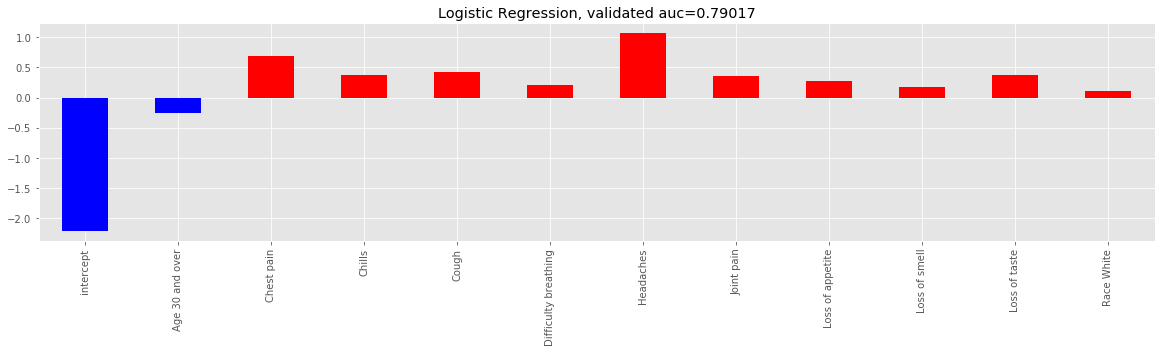

In [88]:
plt.style.use('ggplot')

i = pd.Series([regressor.intercept_[0]], index=['intercept'])
s = pd.concat([c[c > 0], c[c < 0]]).sort_index()
s = pd.concat([i, s])
color = ['r' if v > 0 else 'b' for v in s]

ax = s.plot(kind='bar', color=color, figsize=(20, 4))
_ = ax.set_title(f'Logistic Regression, validated auc={scores.mean():.5f}')

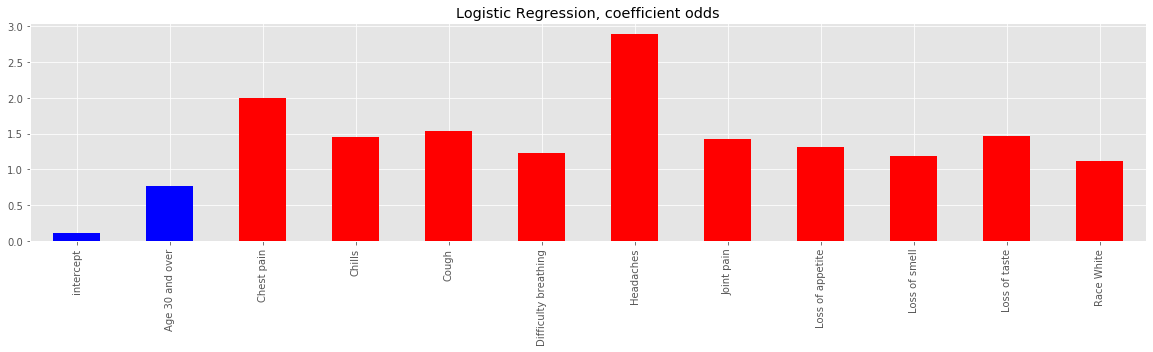

In [89]:
s_odds = np.exp(s)
color = ['r' if v > 1 else 'b' for v in s_odds]

ax = s_odds.plot(kind='bar', color=color, figsize=(20, 4))
_ = ax.set_title(f'Logistic Regression, coefficient odds')

### Tabular output of coefficients with odds

In [90]:
pd.DataFrame({
    'coefficient': s,
    'coefficient_odds': s_odds
}).round(decimals=4)

coefficient  coefficient_odds
intercept                 -2.2125            0.1094
Age 30 and over           -0.2601            0.7710
Chest pain                 0.6929            1.9995
Chills                     0.3731            1.4522
Cough                      0.4291            1.5359
Difficulty breathing       0.2009            1.2225
Headaches                  1.0631            2.8952
Joint pain                 0.3509            1.4204
Loss of appetite           0.2733            1.3143
Loss of smell              0.1747            1.1909
Loss of taste              0.3813            1.4643
Race White                 0.1132            1.1199

In [91]:
(pd.DataFrame({
    'coefficient': s,
    'coefficient_odds': s_odds
}).round(decimals=4)).shape

(12, 2)